**Load libraries and data**

In [2]:
!pip install klib sentencepiece transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import klib
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import T5Tokenizer, MT5ForConditionalGeneration
from tqdm.notebook import tqdm as tqdm_notebook_
from scipy.signal import savgol_filter
import random
import copy
import os

In [4]:
# Mounting the google drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Upload the 'xnli15.tsv' file to the colab directory before running the cell

df = pd.read_csv('/content/drive/MyDrive/LS_NN_NLP/xnli15.tsv', sep='\t')
print('Shape of the Dataframe: ', df.shape)
display(df.head())

Shape of the Dataframe:  (10000, 15)


,ar,bg,de,el,en,es,fr,hi,ru,sw,th,tr,ur,vi,zh
0,وقال، ماما، لقد عدت للمنزل.,"И той каза: Мамо, у дома съм.","und er hat gesagt, Mama ich bin daheim.","Και είπε, Μαμά, έφτασα στο σπίτι.","And he said, Mama, I'm home.","Y él dijo: Mamá, estoy en casa.","Et il a dit, maman, je suis à la maison.","और उसने कहा, माँ, मैं घर आया हूं।","И он сказал: Мама, я дома.","Naye akasema, Mama, niko nyumbani.","และเขาพูดว่า, ม่าม๊า ผมอยู่บ้าน","Ve Anne, evdeyim dedi.",اور اس نے کہا امّی، میں گھر آگیا ہوں۔,"Và anh ấy nói, Mẹ, con đã về nhà.",他说，妈妈，我回来了。
1,حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطا...,"Е, аз дори не мислех за това, но бях толкова р...","Nun, daran dachte ich nicht einmal, aber ich w...","Λοιπόν, δεν το σκέφτηκα καν, αλλά ήμουν τόσο α...","Well, I wasn't even thinking about that, but I...","Bien, ni estaba pensando en eso, pero estaba t...","Eh bien, je ne pensais même pas à cela, mais j...",हालांकि मैं इसके बारे में सोच भी नहीं रहा था ल...,"Ну, я даже не думал об этом, но я был так разо...","Naam, sikukuwa nafikiri juu ya hilo, lakini ni...","ดี, ฉันไม่ได้คิดอะไรเกี่ยวกับเรื่องนี้, แต่ฉัน...","Pekala, bunu hiç düşünmemiştim ancak kafam çok...",میں اس کے بارے میں نہیں سوچھ رہی تھی ، لیکن می...,"Vâng, tôi thậm chí không nghĩ về điều đó, nhưn...",嗯，我根本没想过，但是我很沮丧，最后我又和他说话了。
2,واعتقدت أن ذلك شرف لي ، ولا يزال ، ولايزال ، ك...,"И аз мислех, че това е привилегия, и тя все ощ...","„Und ich dachte, das wäre ein Privileg, und da...","Και σκέφτηκα ότι ήταν ένα προνόμιο, και είναι ...","And I thought that was a privilege, and it's s...","Y pensé que era un privilegio, y todavía es, t...","Et je pensais que c'était un privilège, et ça ...","और मैंने सोचा कि यह एक विशेषाधिकार था, और यह अ...","А я считал это привилегией, и всё-же, и всё-ж...","Nami nilifikiri kwamba ilikuwa ni fursa, na ba...",และฉันนึกว่านั้นเป็นสิทธิพิเศษและมันยังคงเป็น ...,"Ve bunun bir ayrıcalık olduğunu sanıyordum, ve...",اور میں نے سوچا کہ یہ ایک امتیاز تھا، اور یہ ا...,"Và tôi nghĩ đó là một đặc ân, và nó vẫn còn, n...",而我当初认为这是一个特权，我现在仍然这样想，我是唯一的922 Ex-O，也是我的AFFC空军...
3,أخبروني ،إيه، أنه سيتم استدعائي من قبل شاب في ...,"Казаха ми, че накрая ще ми се обади човек, за ...","Sie sagten mir, dass ich am Ende von einem Ker...","Μου είπαν ότι, θα έπρεπε να καλέσω έναν άντρα ...","They told me that, uh, that I would be called ...","Me dijeron que, esto... que un tipo me llamarí...","Ils m'ont dit qu'à la fin, on m'amènerait un h...",उन्होंने मुझसे कहा की अंत में एक व्यक्ति से मी...,"Они сказали, что меня вызовут , чтобы встретит...",Walinieleza ya kwamba mwishowe ningeitiwa jama...,พวกเขาบอกฉันว่าเขาจะเรียกคน ๆ หนึ่งเข้ามาในตอน...,Sonunda tanışmam için bir adam tarafından çağr...,انہوں نے مجھے بتایا تھا کے آخر میں مجھ سے ملنے...,"Họ nói với tôi rằng, ừ, rằng tôi sẽ được gọi b...",他们告诉我，呃，我最后会被叫到一个人那里去见面。
4,هناك الكثير تستطيع التحدث عنه وأنا سوف أتاجاو...,"Има толкова много, което може да се разкаже за...",Es gibt so viel was ich darüber erzählen könnt...,Υπάρχουν τόσα πολλά που θα μπορούσες να μιλήσε...,There's so much you could talk about on that I...,"Hay tanto que se puede decir sobre eso, que se...",Il y a tellement de choses dont vous pourriez ...,इतना है कि आप इसके बारे में बात कर सकते हैं कि...,"Об этом можно так много говорить, что я опущу ...",Kuna mengi ambayo unaweza kuzungumzia kuhusu h...,มันมีอีกมากที่คุณสามารถพูดคุยเกี่ยวกับสิ่งนั้น...,Bu konu hakkında söyleyebileceğin çok şey var ...,بہت اتنا ہے کہ آپ اس کے بارے میں بات کر سکتے ہ...,Có rất nhiều điều bạn có thể nói mà tôi sẽ chỉ...,你可以讲的太多了，我就不提了。


In [6]:
# Display the column headers represening each language
print(df.columns)

Index(['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr',
       'ur', 'vi', 'zh'],
      dtype='object')


In [8]:
# Modify the structure of the dataframe for the required downstream task
get_data = []
for col in df.columns:
  for row in df[col]:
    get_data.append([row, col])

df = pd.DataFrame(get_data, columns=['input_text','target_text'])
display(df)


,input_text,target_text
0,وقال، ماما، لقد عدت للمنزل.,ar
1,حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطا...,ar
2,واعتقدت أن ذلك شرف لي ، ولا يزال ، ولايزال ، ك...,ar
3,أخبروني ،إيه، أنه سيتم استدعائي من قبل شاب في ...,ar
4,هناك الكثير تستطيع التحدث عنه وأنا سوف أتاجاو...,ar
...,...,...
149995,戴维森不应该以骨头和烤饼听起来一样的方式说话。,zh
149996,"如果戴维森押韵饼和骨头的话, 那就更好了。",zh
149997,价值25美元的20万字小说价格合理。,zh
149998,"25美元的20万字的小说就是每美元4,000字。",zh


In [9]:
# Data cleaning
df=klib.data_cleaning(df)
df=df.drop_duplicates(subset='input_text', keep=False)


Shape of cleaned data: (149935, 2) - Remaining NAs: 0


Dropped rows: 65
     of which 65 duplicates. (Rows (first 150 shown): [6857, 7729, 9884, 12718, 13918, 15238, 16857, 23871, 24239, 33918, 46857, 52305, 55046, 58715, 59687, 61237, 62324, 63918, 65271, 72853, 73873, 75977, 78367, 85271, 92321, 95238, 98105, 103393, 103871, 109555, 116857, 116878, 119674, 121001, 121144, 121204, 121224, 121269, 121366, 121371, 121382, 121487, 121678, 121933, 121943, 121978, 122000, 122139, 122199, 122321, 122420, 122475, 124419, 125471, 125845, 125860, 128946, 130755, 132988, 133918, 137847, 143683, 145271, 145673, 146857])

Dropped columns: 0
     of which 0 single valued.     Columns: []
Dropped missing values: 0
Reduced memory by at least: 1.0 MB (-43.67%)



In [10]:
# Adding prefix text to the input, which helps the model to understand the fine-tuning task objective
df['input_text'] = '<idf.lang> '+df['input_text']
display(df)

,input_text,target_text
0,<idf.lang> وقال، ماما، لقد عدت للمنزل.,ar
1,<idf.lang> حسنا ، لم أكن أفكر حتى حول ذلك ، لك...,ar
2,<idf.lang> واعتقدت أن ذلك شرف لي ، ولا يزال ، ...,ar
3,<idf.lang> أخبروني ،إيه، أنه سيتم استدعائي من ...,ar
4,<idf.lang> هناك الكثير تستطيع التحدث عنه وأنا...,ar
...,...,...
149930,<idf.lang> 戴维森不应该以骨头和烤饼听起来一样的方式说话。,zh
149931,"<idf.lang> 如果戴维森押韵饼和骨头的话, 那就更好了。",zh
149932,<idf.lang> 价值25美元的20万字小说价格合理。,zh
149933,"<idf.lang> 25美元的20万字的小说就是每美元4,000字。",zh


In [11]:
# Splitting the dataset into train, validation, and test
train_val_set, test_df = train_test_split(df, test_size=0.21, random_state=42)
train_set, eval_set = train_test_split(train_val_set, test_size=0.24, random_state=42)
print('Training dataset shape: ', train_set.shape)
print('Validation dataset shape: ', eval_set.shape)
print('Testing dataset shape: ', test_df.shape)


Training dataset shape:  (89959, 2)
Validation dataset shape:  (28409, 2)
Testing dataset shape:  (31466, 2)


In [12]:
model_repo = 'google/mt5-small'
model_path = '/content/drive/MyDrive/LS_NN_NLP/fine-tuned_mt5/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

**Load tokenizer and model**

In [13]:
# Loading the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = MT5ForConditionalGeneration.from_pretrained(model_repo)
model = model.cuda()

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


**Add prefixes to tokenizer**

In [14]:
len(tokenizer.vocab)

250100

In [15]:
print(model.config.max_length)

20


In [16]:
# Adding the prefix <idf.lang> as a special token
SPECIAL_TOKEN_MAPPING = {
    'identify language': '<idf.lang>'
}
special_tokens_dict = {'additional_special_tokens': list(SPECIAL_TOKEN_MAPPING.values())}
special_tokens_dict

{'additional_special_tokens': ['<idf.lang>']}

In [17]:
# Adding the special tokens to the tokenizer
tokenizer.add_special_tokens(special_tokens_dict)

1

In [18]:
len(tokenizer)

250101

In [19]:
# display all special tokens
tokenizer.all_special_tokens

['</s>', '<unk>', '<pad>', '<idf.lang>']

In [20]:
model.config.vocab_size

250112

In [21]:
# resize the input token embeddings of the model if len(tokenizer) != model.config.vocab_size
model.resize_token_embeddings(len(tokenizer))

Embedding(250101, 512)

**Encode Inputs**

Text(0, 0.5, 'frequency')

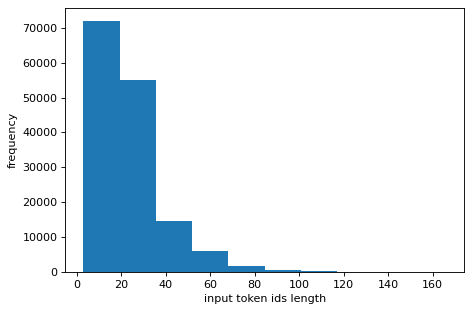

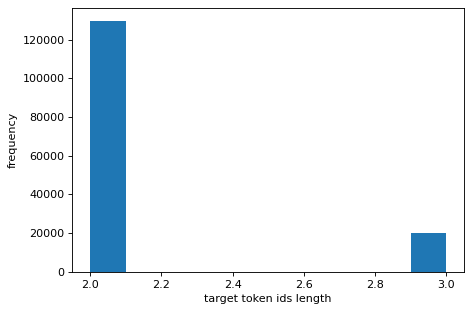

In [22]:
# This cell encodes all the entries in the dataset to plot the token lengths histogram of
# i/p and o/p texts

token_container = []

for row in df['input_text']:
  input_ids = tokenizer.encode(row, return_tensors='pt').cuda()
  token_container.append(len(input_ids[0]))

token_container.sort(reverse=True)

plt.figure(figsize=(6, 4),tight_layout=True, dpi=80)
plt.hist(token_container)
plt.xlabel('input token ids length')
plt.ylabel('frequency')


label_container = []

for row in df['target_text']:
  input_ids = tokenizer.encode(row, return_tensors='pt').cuda()
  label_container.append(len(input_ids[0]))


label_container.sort(reverse=True)

plt.figure(figsize=(6, 4),tight_layout=True, dpi=80)
plt.hist(label_container)
plt.xlabel('target token ids length')
plt.ylabel('frequency')

In [23]:
# Large input sequence length makes the model better but makes the training computationally very intensive
max_input_seq_len = 40
max_target_seq_len = 3

In [24]:
# function to encode a given string and return token ids

def embed_str(text, tokenizer, seq_len):
  """ Tokenize, pad to max length and encode to ids
      Returns tensor with token ids """
  input_ids = tokenizer.encode(
      text=text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

In [25]:
# Testing the embed_str function

print(train_set['input_text'].iloc[0])
t1 = embed_str(train_set['input_text'].iloc[0],tokenizer,max_input_seq_len)
print(t1)
tokens = tokenizer.convert_ids_to_tokens(t1)
print(tokens)

<idf.lang> सांप नदी सांपों  से भरा है।
tensor([250100,   4736,  27185,    259,    863,   7553,   4736,  27185,   1396,
          1162,   2573,   3409,    830,    378,      1,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0])
['<idf.lang>', '▁सा', 'ंप', '▁', 'न', 'दी', '▁सा', 'ंप', 'ों', '▁से', '▁भ', 'रा', '▁है', '।', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [26]:
# Visualizing how the target texts are tokenized

uniq_lab = df['target_text'].unique()
for uni in uniq_lab:
  t1 = embed_str(uni,tokenizer,max_target_seq_len)
  tokens = tokenizer.convert_ids_to_tokens(t1)
  print('Input ID: ',t1,', Tokens: ', tokens,', Decoded text: ',tokenizer.decode(t1))

Input ID:  tensor([798,   1,   0]) , Tokens:  ['▁ar', '</s>', '<pad>'] , Decoded text:  ar</s><pad>
Input ID:  tensor([ 259, 5979,    1]) , Tokens:  ['▁', 'bg', '</s>'] , Decoded text:  bg</s>
Input ID:  tensor([269,   1,   0]) , Tokens:  ['▁de', '</s>', '<pad>'] , Decoded text:  de</s><pad>
Input ID:  tensor([362,   1,   0]) , Tokens:  ['▁el', '</s>', '<pad>'] , Decoded text:  el</s><pad>
Input ID:  tensor([289,   1,   0]) , Tokens:  ['▁en', '</s>', '<pad>'] , Decoded text:  en</s><pad>
Input ID:  tensor([655,   1,   0]) , Tokens:  ['▁es', '</s>', '<pad>'] , Decoded text:  es</s><pad>
Input ID:  tensor([8967,    1,    0]) , Tokens:  ['▁fr', '</s>', '<pad>'] , Decoded text:  fr</s><pad>
Input ID:  tensor([1823,    1,    0]) , Tokens:  ['▁hi', '</s>', '<pad>'] , Decoded text:  hi</s><pad>
Input ID:  tensor([6079,    1,    0]) , Tokens:  ['▁ru', '</s>', '<pad>'] , Decoded text:  ru</s><pad>
Input ID:  tensor([22829,     1,     0]) , Tokens:  ['▁sw', '</s>', '<pad>'] , Decoded text:  sw</

In [27]:
# function to encode a given row from the dataset, containing 'input_text' and 'target_text'
# returns input and target token ids

def embed_row(row, tokenizer, seq_inp_len, seq_tar_len):
  """Encode input and tagret texts from single row"""
  """Returns input and output token ids"""
  input_text = row['input_text']
  target_text = row['target_text']

  if input_text is None or target_text is None:
    return None

  input_token_ids = embed_str(
      input_text, tokenizer, seq_inp_len)

  target_token_ids = embed_str(
      target_text, tokenizer, seq_tar_len)

  return input_token_ids, target_token_ids

In [28]:
# function to encode a single batch and return input and output batch token ids

def embed_batch(batch, tokenizer):
  """Encode a single batch"""
  """Returns input and output batch token ids"""
  inputs = []
  targets = []
  for index, row in batch.iterrows():
    #gets input and output tocken ids
    formatted_data = embed_row(
        row, tokenizer, max_input_seq_len, max_target_seq_len)
#    print("i/o tocken ids:",formatted_data)
    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    #unsqueeze(input, dim) returns a new tensor with a dimension of size one inserted at the specified position
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
#  print('squeezed tocken ids:',inputs)

#Concatenate the given sequence of seq tensors in the given dimension
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

In [29]:
# function to create a generator object to generate batches of data

def data_generator(dataset, tokenizer, batch_size=32):
  """"generates batches"""
  #shuffle the data
  dataset=dataset.sample(frac=1).reset_index(drop=True)

  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield embed_batch(raw_batch, tokenizer)

In [30]:
# Testing data generator

data_gen = data_generator(train_set, tokenizer, 8)
data_batch = next(data_gen)
#print('data_batch:',data_batch)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)


Input shape: torch.Size([8, 40])
Output shape: torch.Size([8, 3])


**Training**


In [31]:
# defining the parameters required for fine-tuning

n_epochs = 1
train_batch_size = 16
eval_batch_size = 8
lr = 5e-4

n_batches = int(np.ceil(len(train_set) / train_batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

val_freq = np.ceil(10*eval_batch_size*n_batches/len(eval_set))*2
while val_freq%5 != 0:
  val_freq += 1
val_freq = round(val_freq)

print_freq = val_freq

checkpoint_freq = np.ceil(n_batches/10)
while checkpoint_freq%100 != 0:
  checkpoint_freq -= 1
checkpoint_freq = round(checkpoint_freq)


In [32]:
print('Total Training Steps(Batches) per Epoch: '+str(n_batches))
print('Printing & Validation Frequency: '+str(val_freq))
print('Checkpoint Saving Frequency: '+str(checkpoint_freq))

Total Training Steps(Batches) per Epoch: 5623
Printing & Validation Frequency: 35
Checkpoint Saving Frequency: 500


In [33]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
# list to store the training and validation losses

losses = []
val_losses = []

In [35]:
# function to evaluate the model during training at a given frequency

def eval_model(model, val_generator_object, max_iters=6):
  """evaluate the model on small validation data"""

  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(val_generator_object):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [36]:
# fine-tuning the model and save the checkpoints

for epoch_idx in range(n_epochs):
  # generate batch data
  train_generator = data_generator(train_set, tokenizer, train_batch_size)
  val_generator = data_generator(eval_set, tokenizer, eval_batch_size)

  for batch_idx, (input_batch, label_batch) in tqdm_notebook_(enumerate(train_generator), total=n_batches):
    #zeroes all the gradients before the calculation
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(input_ids = input_batch, labels = label_batch)

    # Calculate loss
    loss = model_out.loss
    # loss.item() gets the scalar value held in the loss.  item() turns a Tensor into a Python number
    losses.append(loss.item())
    #backpropagation - computing the gradient of the loss function with respect to each weight
    loss.backward()
    # updating weights to minimize loss
    optimizer.step()
    #You call scheduler.step() every batch, right after optimizer.step(), to update the learning rate.
    scheduler.step()

    # Print training update info
    # At an interval of print_freq or val_freq
    if (batch_idx + 1) % print_freq == 0:
      #average loss for the last 'print_freq' batches
      avg_loss = np.mean(losses[-print_freq:])
      val_loss = eval_model(model, val_generator)
      print('Epoch: {} | Step: {} | Avg. train loss: {:.3f} | Avg. val loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, val_loss, scheduler.get_last_lr()[0]))
      val_losses.append(val_loss)


    # save the model for every 'checkpoint_freq' steps
    if (batch_idx + 1) % checkpoint_freq == 0:
      torch.save(model.state_dict(), os.path.join(model_path+ 'Step-{}_checkpoint_lang_pred.pt'.format(batch_idx + 1)))

torch.save(model.state_dict(), os.path.join(model_path+ 'Step-{}_checkpoint_lang_pred.pt'.format(batch_idx + 1)))

  0%|          | 0/5623 [00:00<?, ?it/s]

Epoch: 1 | Step: 35 | Avg. train loss: 24.126 | Avg. val loss: 13.176 | lr: 0.0003125
Epoch: 1 | Step: 70 | Avg. train loss: 10.159 | Avg. val loss: 7.256 | lr: 0.0004987425902640561
Epoch: 1 | Step: 105 | Avg. train loss: 4.918 | Avg. val loss: 3.211 | lr: 0.0004955990659241962
Epoch: 1 | Step: 140 | Avg. train loss: 2.429 | Avg. val loss: 1.907 | lr: 0.0004924555415843362
Epoch: 1 | Step: 175 | Avg. train loss: 1.504 | Avg. val loss: 1.101 | lr: 0.0004893120172444763
Epoch: 1 | Step: 210 | Avg. train loss: 0.891 | Avg. val loss: 0.780 | lr: 0.0004861684929046165
Epoch: 1 | Step: 245 | Avg. train loss: 0.709 | Avg. val loss: 0.609 | lr: 0.0004830249685647566
Epoch: 1 | Step: 280 | Avg. train loss: 0.619 | Avg. val loss: 0.572 | lr: 0.0004798814442248967
Epoch: 1 | Step: 315 | Avg. train loss: 0.485 | Avg. val loss: 0.421 | lr: 0.0004767379198850368
Epoch: 1 | Step: 350 | Avg. train loss: 0.393 | Avg. val loss: 0.320 | lr: 0.000473594395545177
Epoch: 1 | Step: 385 | Avg. train loss: 0.

In [37]:
# save the training and validation loss values

if not os.path.exists('/content/drive/MyDrive/LS_NN_NLP/Loss'):
  os.mkdir('/content/drive/MyDrive/LS_NN_NLP/Loss')

pd.DataFrame(losses).to_csv("/content/drive/MyDrive/LS_NN_NLP/Loss/train_loss.csv")
pd.DataFrame(val_losses).to_csv("/content/drive/MyDrive/LS_NN_NLP/Loss/val_loss.csv")

In [38]:
# Load the loss values

train_loss_= pd.read_csv('/content/drive/MyDrive/LS_NN_NLP/Loss/train_loss.csv', index_col=0)
val_loss_= pd.read_csv('/content/drive/MyDrive/LS_NN_NLP/Loss/val_loss.csv', index_col=0)


Text(0.5, 0, 'Steps')

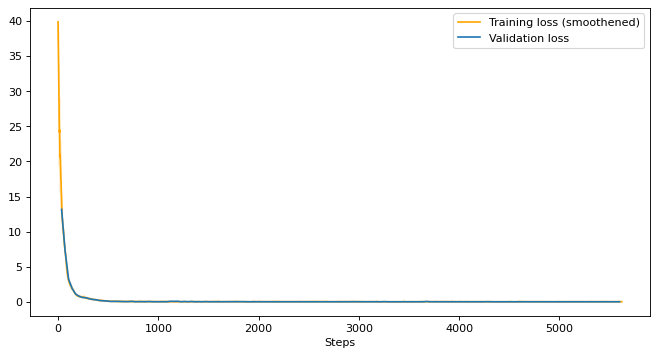

In [39]:
# visualizing the training and validation losses

# Actual training loss with low opacity
fig = plt.figure(figsize=(10, 5), dpi=80)
plt.plot(train_loss_, alpha=0.15, color='orange')

# smoothening the training loss
# window size is chosen depending upon the amount of smoothening required
window = 11
order = 1
y_ = savgol_filter(train_loss_['0'], window, order)
plt.plot(y_, color='orange', label='Training loss (smoothened)')

# Validation loss
val_loss_df = copy.deepcopy(val_loss_)
val_loss_df.index = (val_loss_.index+1)*val_freq
plt.plot(val_loss_df, label='Validation loss')

plt.legend(loc="upper right")
plt.xlabel('Steps')

# save the plot if needed
# fig.savefig('/content/gdrive/MyDrive/Loss/Loss_Plot.png', dpi=fig.dpi)

**Model Testing**

In [40]:
# function to test the model on 'max_iter' examples

def test_model(test_df, tokenizer, wrong_prediction, max_iter):

  max_test_iters = max_iter
  count_ = 0

  for _ in range(max_test_iters):
    num = random.randint(0,len(test_df['input_text'])-1)
    test = test_df.iloc[num]

    input_ids = embed_str(text = test['input_text'], tokenizer = tokenizer, seq_len = 40)
    input_ids = input_ids.unsqueeze(0).cuda()

    #print('Truncated input text:', tokenizer.convert_tokens_to_string(
    #  tokenizer.convert_ids_to_tokens(input_ids[0])))

    output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
    # print(output_tokens)
    for token_set in output_tokens:
      prediction = tokenizer.decode(token_set,skip_special_tokens=True)
      if prediction == test['target_text']:
        count_ += 1
      else:
        wrong_prediction.append([test['input_text'], test['target_text'], prediction])

  return count_/max_test_iters, wrong_prediction

In [42]:
# test the model on multiple batches to find average test accuracy.
# wrong predictions are saved to 'wrong_predictions.csv' file for further analysis.

Test_acc_values = []
wrong_pred = []
test_n_batches = 20
print('Model testing on test dataset: \n')
for _ in tqdm_notebook_(range(test_n_batches)):
  acc, wrong_pred = test_model(test_df, tokenizer, wrong_pred, max_iter=50)
  Test_acc_values.append(acc)


print('Avg. Test Accuracy: {:.4f}'.format(np.mean(Test_acc_values)))
wrong_pred_df = pd.DataFrame (wrong_pred, columns = ['Input_text', 'True_target', 'Predicted'])
wrong_pred_df.to_csv("/content/drive/MyDrive/LS_NN_NLP/wrong_predictions.csv")


Model testing on test dataset: 



  0%|          | 0/20 [00:00<?, ?it/s]

Avg. Test Accuracy: 0.9970
